In [1]:
## Import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier

In [2]:
## Import CSVs and break into training and testing tables

train = pd.read_csv('train.csv').convert_dtypes()

train_x = train.drop(columns=['Survived'], axis=1)
train_y = pd.DataFrame(train, columns=['Survived'])

test_x = pd.read_csv('test.csv').convert_dtypes()

<AxesSubplot:xlabel='Age', ylabel='Count'>

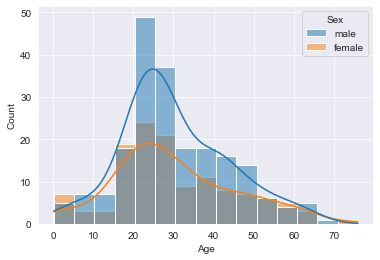

In [3]:
## Generate a histogram of Age by Sex

sns.set_style('darkgrid')
sns.histplot(data=test_x, x='Age', hue='Sex', kde=True)

In [4]:
## Add a way to look if one passenger (of a group of two) is missing age data, then populate it assuming the other is the same age

In [5]:
## If no other way to predict the person's age, then populate based off the distribution of known ages

In [6]:
## Calculate average age for each Sex and Pclass combination

avg_age = train_x.pivot_table(
    columns=['Sex', 'Pclass'], values='Age', aggfunc='mean').mean()

avg_age = avg_age.reset_index()
avg_age.columns = ['Sex', 'Pclass', 'Value']

print(avg_age)


      Sex  Pclass      Value
0  female       1  34.611765
1  female       2  28.722973
2  female       3  21.750000
3    male       1  41.281386
4    male       2  30.740707
5    male       3  26.507589


In [7]:
## Replace missing ages with average age for Sex and Pclass

train_x = train_x.merge(avg_age, left_on=['Sex', 'Pclass'], right_on=[
                    'Sex', 'Pclass'], how='left')
train_x['Age'].fillna(train_x['Value'], inplace=True)

test_x = test_x.merge(avg_age, left_on=['Sex', 'Pclass'], right_on=[
                  'Sex', 'Pclass'], how='left')
test_x['Age'].fillna(test_x['Value'], inplace=True)

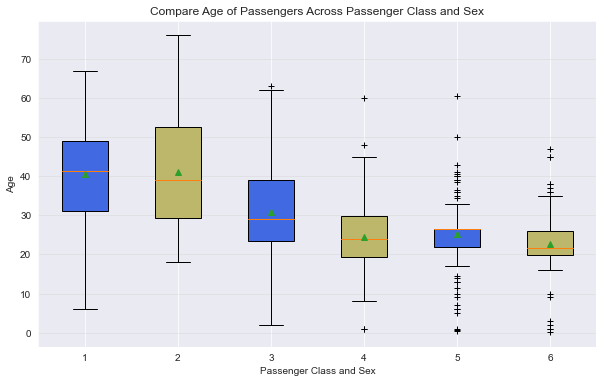

In [8]:
## Plot Age vs Sex and Pclass

pclass1_male = test_x[(test_x['Pclass'] == 1) & (test_x['Sex'] == 'male')]
pclass2_male = test_x[(test_x['Pclass'] == 2) & (test_x['Sex'] == 'male')]
pclass3_male = test_x[(test_x['Pclass'] == 3) & (test_x['Sex'] == 'male')]

pclass1_female = test_x[(test_x['Pclass'] == 1) & (test_x['Sex'] == 'female')]
pclass2_female = test_x[(test_x['Pclass'] == 2) & (test_x['Sex'] == 'female')]
pclass3_female = test_x[(test_x['Pclass'] == 3) & (test_x['Sex'] == 'female')]

pclass_sex = [pclass1_male['Age'],pclass1_female['Age'],pclass2_male['Age'],pclass2_female['Age'],pclass3_male['Age'],pclass3_female['Age']]

fig, ax = plt.subplots(figsize=(10,6))

bp = ax.boxplot(pclass_sex, notch=0, sym='+', vert=1, showmeans=True, patch_artist=True, medianprops={})

box_colors = ['darkkhaki','royalblue']
i = 0
for patch in bp['boxes']:
    if i % 2:
        patch.set(facecolor=box_colors[0])
    else:
        patch.set(facecolor=box_colors[1])
    i += 1

ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
ax.set(
    axisbelow=True,
    title='Compare Age of Passengers Across Passenger Class and Sex',
    xlabel='Passenger Class and Sex',
    ylabel='Age'
    )

plt.show()

In [9]:
## Convert male/female text to numbers

train_x.loc[train_x['Sex'] == 'male', 'Sex_as_num'] = 0
train_x.loc[train_x['Sex'] == 'female', 'Sex_as_num'] = 1

test_x.loc[test_x['Sex'] == 'male', 'Sex_as_num'] = 0
test_x.loc[test_x['Sex'] == 'female', 'Sex_as_num'] = 1

In [10]:
## Remove text columns from training and testing dataframes and index

train_x.set_index('PassengerId', inplace=True)
train_x.drop(columns=['Name', 'Ticket', 'Cabin', 'Fare',
           'Embarked', 'Sex', 'Value'], inplace=True)

train_y.set_index(train_x.index, inplace=True)

test_x.set_index('PassengerId', inplace=True)
test_x.drop(columns=['Name', 'Ticket', 'Cabin', 'Fare',
          'Embarked', 'Sex', 'Value'], inplace=True)

In [11]:
## Apply KNN algorithm to training set and use it to predict test set

knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(train_x, train_y)

test_y = knn.predict(test_x)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:200: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [12]:
## Format output table for submission and save as CSV

test_x['Survived'] = test_y

submit = test_x.drop(
    columns=['Pclass', 'Age', 'SibSp', 'Parch', 'Sex_as_num']).reset_index()
submit.to_csv('submission.csv', index=False)

In [13]:
## Import answer CSV for comparison

test_y_answer = pd.read_csv('answer.csv').convert_dtypes()

In [14]:
## Format answer table

test_y_answer.set_index(test_x.index, inplace=True)
test_y_answer.drop(columns=['PassengerId'], inplace=True)

test_x['Survived_answer'] = test_y_answer
test_x = test_x.convert_dtypes()

In [15]:
## Calculate prediction score

cnt_total = len(test_x)
cnt_right = len(test_x[test_x["Survived"] == test_x["Survived_answer"]])
cnt_wrong = len(test_x[test_x["Survived"] != test_x["Survived_answer"]])

print("Score = " + str(100 * cnt_right / cnt_total))

Score = 72.2488038277512


In [16]:
## Count categories for wrong answers

test_x['Prediction Correct'] = np.where((test_x["Survived"] == test_x["Survived_answer"]),True,False)

test_x['Still Alive'] = np.where((test_x["Survived"] != test_x["Survived_answer"]) & (test_x["Survived"] == 0) & (test_x["Survived_answer"] == 1),True,False)

test_x['Actually Died'] = np.where((test_x["Survived"] != test_x["Survived_answer"]) & (test_x["Survived"] == 1) & (test_x["Survived_answer"] == 0),True,False)